<a href="https://colab.research.google.com/github/oownus1/AutoML/blob/main/Prophet_%EC%8B%9C%EA%B3%84%EC%97%B4%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%98%88%EC%B8%A1_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 한글 폰트 설치

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,186 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

# Facebook Prophet을 활용한 시계열 데이터 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- Facebook Prophet을 활용하여 주가 예측

## 필요한 모듈 import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic') 

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [3]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import FinanceDataReader as fdr

In [5]:
# 삼성전자 종목코드: 005930
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [6]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-27,61300,61900,61200,61800,7320997,0.001621
2022-07-28,62300,62600,61600,61900,10745302,0.001618
2022-07-29,62400,62600,61300,61400,15093120,-0.008078
2022-08-01,61000,61700,60300,61300,13154816,-0.001629
2022-08-02,61200,61900,61000,61700,13515486,0.006525


**미국 주식 데이터**도 가져올 수 있습니다.

In [7]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [8]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-07-26,151.60,152.26,153.09,150.80,55140000.0,-0.0088
2022-07-27,156.79,152.58,157.33,152.16,78620000.0,0.0342
2022-07-28,157.35,156.98,157.64,154.41,81380000.0,0.0036
2022-07-29,162.51,161.24,163.63,159.50,101790000.0,0.0328
2022-08-01,161.51,161.08,163.57,160.89,64380000.0,-0.0062


### 비트코인 시세

In [9]:
#시작일 지정 can
btc = fdr.DataReader('BTC/KRW', '2018-01-01')
btc

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2018-01-01,18655000,19208000,19296000,18362000,10240.0,-0.0288
2018-01-02,19838000,18655000,20800000,18570000,17460.0,0.0634
2018-01-03,20419000,19838000,20810000,19800000,15670.0,0.0293
2018-01-04,21576000,20419000,21830000,19891000,14730.0,0.0567
2018-01-05,25026000,21576000,25988000,21046000,25290.0,0.1599
...,...,...,...,...,...,...
2022-07-29,31416000,31234000,31925000,30927000,1780.0,0.0058
2022-07-30,31263000,31423000,32485000,31191000,1660.0,-0.0049
2022-07-31,30749000,31272000,31790000,30729000,1600.0,-0.0164


## 시세에 대한 그래프 시각화

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


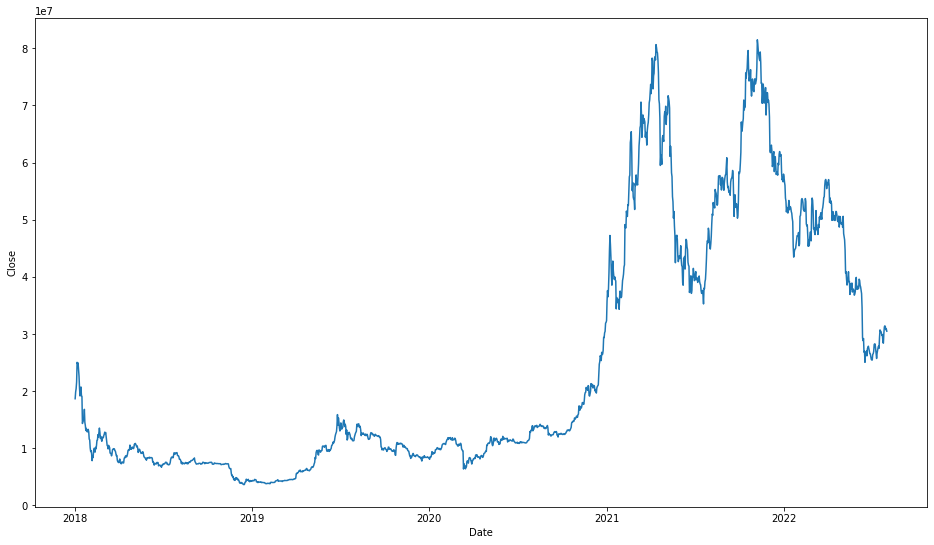

In [10]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=btc.index, y='Close', data=btc)
plt.show()

**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [11]:
# 비트코인 시세
btc = fdr.DataReader('BTC/KRW', '2019-01-01', '2020-12-01')
btc

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-01-01,4289000,4199000,4300000,4137000,3230.0,0.0214
2019-01-02,4345000,4294000,4360000,4244000,3860.0,0.0131
2019-01-03,4282000,4352000,4367000,4259000,15370.0,-0.0145
2019-01-04,4309000,4286000,4334000,4243000,19200.0,0.0063
2019-01-05,4297000,4309000,4354000,4278000,24870.0,-0.0028
...,...,...,...,...,...,...
2020-11-27,19119000,19236000,19236000,19119000,1440.0,-0.0067
2020-11-28,19480000,19118000,19480000,19118000,1610.0,0.0189
2020-11-29,20002000,19480000,20002000,19281000,830.0,0.0268


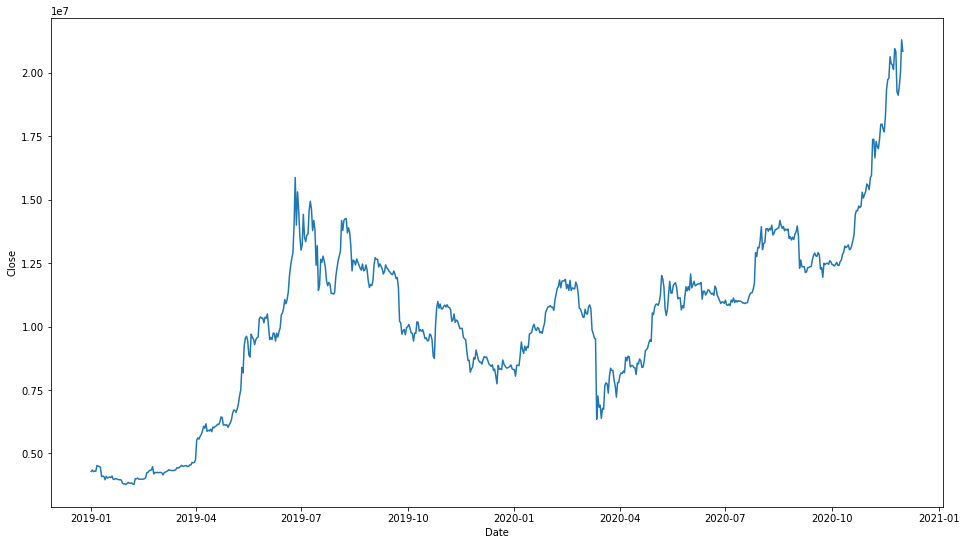

In [12]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=btc.index, y='Close', data=btc)
plt.show()

그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

## 주가데이터 가져오기

In [13]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [14]:
stock = fdr.DataReader(STOCK_CODE)

In [15]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-05-26,875,893,837,847,422200,NaN
1998-05-27,921,921,822,873,596090,0.030697
1998-05-28,876,977,875,977,835549,0.119129
1998-05-29,977,1007,969,996,717510,0.019447
1998-05-30,986,986,934,936,336920,-0.060241


In [16]:
stock.index

DatetimeIndex(['1998-05-26', '1998-05-27', '1998-05-28', '1998-05-29',
               '1998-05-30', '1998-06-01', '1998-06-02', '1998-06-03',
               '1998-06-05', '1998-06-08',
               ...
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-08-01', '2022-08-02'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [17]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-05-26,875,893,837,847,422200,NaN
1998-05-27,921,921,822,873,596090,0.030697
1998-05-28,876,977,875,977,835549,0.119129
1998-05-29,977,1007,969,996,717510,0.019447
1998-05-30,986,986,934,936,336920,-0.060241


## 시각화

Text(0, 0.5, 'price')

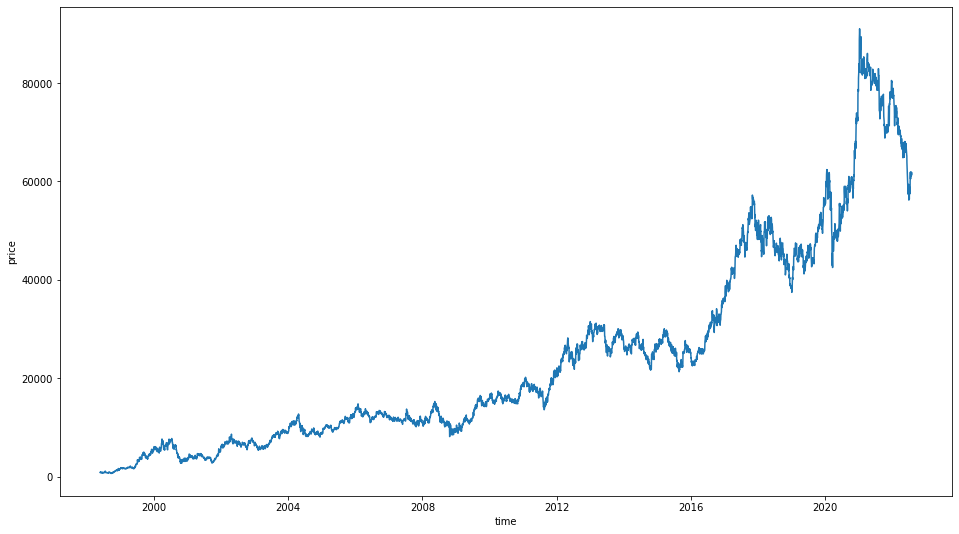

In [18]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


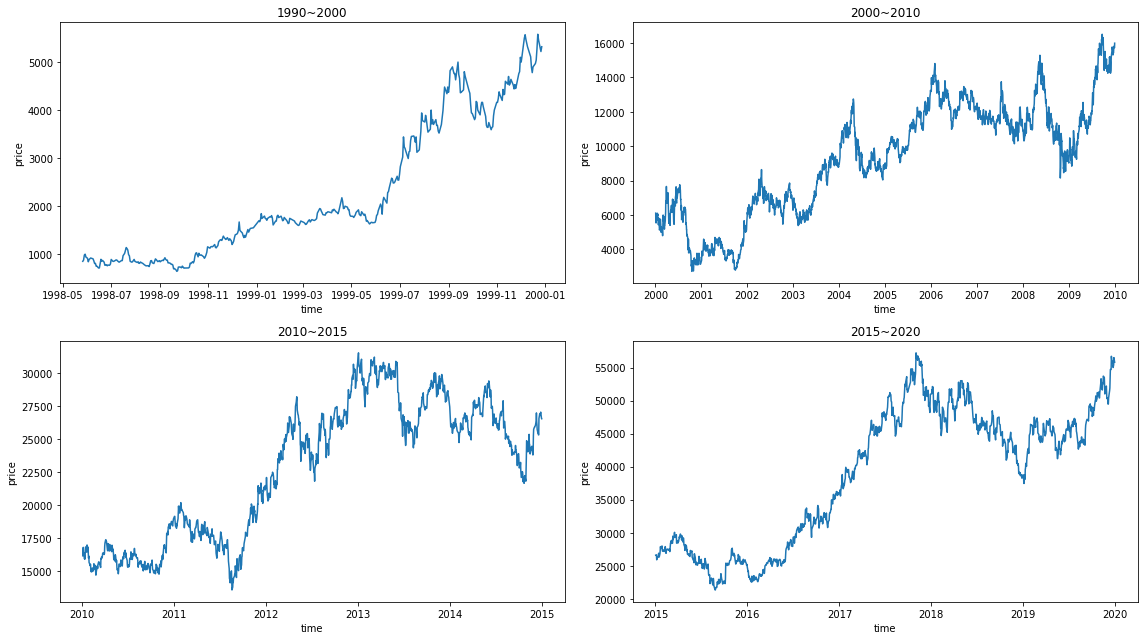

In [19]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [20]:
stock = fdr.DataReader(STOCK_CODE, '2019')

## Prophet

### 모듈 import

In [21]:
#예측 라이브러리 설치
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

### 컬럼

- 반드시 **y** 컬럼과 **ds** 컬럼이 존재해야합니다.
- 예측 값은 **y**, 시계열 데이터는 **ds**에 지정합니다.

In [ ]:
#반드시 소문자로 지정 

In [22]:
stock['y'] = stock['Close']
stock['ds'] = stock.index

In [23]:
stock.head()

,Open,High,Low,Close,Volume,Change,y,ds
Date,,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,0.001292,38750,2019-01-02
2019-01-03,38300,38550,37450,37600,12471493,-0.029677,37600,2019-01-03
2019-01-04,37450,37600,36850,37450,14108958,-0.003989,37450,2019-01-04
2019-01-07,38000,38900,37800,38750,12748997,0.034713,38750,2019-01-07
2019-01-08,38000,39200,37950,38100,12756554,-0.016774,38100,2019-01-08


### prophet 객체 선언 및 학습

In [24]:
m = Prophet()
m.fit(stock)

08:43:07 - cmdstanpy - INFO - Chain [1] start processing
08:43:07 - cmdstanpy - INFO - Chain [1] done processing


**period**에 예측 하고 싶은 기간을 입력 합니다.

예측할 시계열 row가 추가 됩니다.

`periods`에 예측할 기간을 입력합니다.

In [25]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
911,2022-08-28
912,2022-08-29
913,2022-08-30
914,2022-08-31
915,2022-09-01


- `predict`로 예측을 진행합니다.
- `predict` 안에는 이전 단계에서 만들어준 future 데이터프레임을 입력합니다.


In [26]:
#미래 예측 can
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
911,2022-08-28,59928.030386,54029.387917,59224.028340,59701.725533,60156.673682,-3288.821056,-3288.821056,-3288.821056,1945.793501,1945.793501,1945.793501,-5234.614557,-5234.614557,-5234.614557,0.0,0.0,0.0,56639.209330
912,2022-08-29,59872.572445,51476.613019,56095.496676,59630.387223,60112.608943,-6027.351152,-6027.351152,-6027.351152,-843.503586,-843.503586,-843.503586,-5183.847566,-5183.847566,-5183.847566,0.0,0.0,0.0,53845.221293
913,2022-08-30,59817.114504,51610.685966,56527.503105,59553.570123,60078.267329,-5761.681962,-5761.681962,-5761.681962,-651.055943,-651.055943,-651.055943,-5110.626019,-5110.626019,-5110.626019,0.0,0.0,0.0,54055.432542
914,2022-08-31,59761.656563,51415.853141,56486.069295,59477.840326,60034.261828,-5761.141433,-5761.141433,-5761.141433,-744.614134,-744.614134,-744.614134,-5016.527299,-5016.527299,-5016.527299,0.0,0.0,0.0,54000.515129
915,2022-09-01,59706.198621,51444.029185,56410.144659,59398.729540,59995.381246,-5721.531451,-5721.531451,-5721.531451,-818.081810,-818.081810,-818.081810,-4903.449641,-4903.449641,-4903.449641,0.0,0.0,0.0,53984.667170


In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-40:-20]

,ds,yhat,yhat_lower,yhat_upper
876,2022-07-20,60061.657029,57614.679480,62714.290899
877,2022-07-21,60039.597849,57559.894566,62532.423675
878,2022-07-22,60064.619003,57654.616813,62553.205608
879,2022-07-25,60098.954795,57568.395079,62717.322355
880,2022-07-26,60273.397037,57661.991735,62696.589429
881,2022-07-27,60143.176918,57835.270537,62580.663781
882,2022-07-28,60013.286050,57637.584360,62752.009449
883,2022-07-29,59920.005631,57428.463670,62470.063473
884,2022-08-01,59551.775051,57117.009462,62083.139827
885,2022-08-02,59581.936509,56956.951189,62206.469725


### 시각화

`plot`은 트렌드와 함께 예측된 결과물을 시각화하여 보여줍니다.

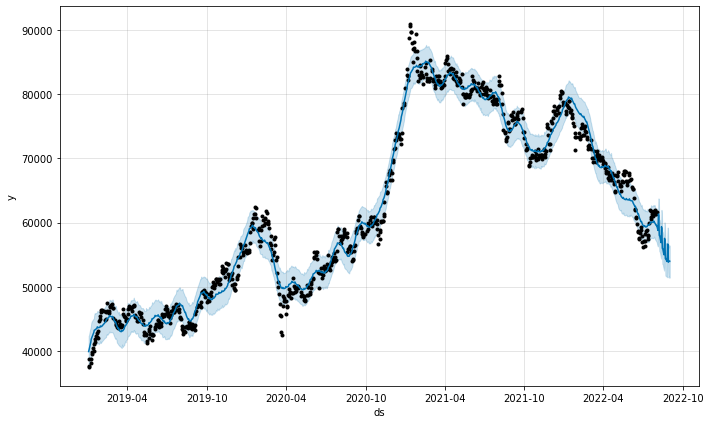

In [28]:
#시각화로 예측 결과 보여준다.
fig = m.plot(forecast)
#예측 데이터 보고서 만들 때 -> 시각화 그래프 위에서 우측버튼 클릭 후 복붙 하면된다. 

### plotly 활용

In [29]:
#인터렉티브 시각화라고 한다. 
#아래 선으로 전체적인 흐름도 볼 수 있다. 
fig = plot_plotly(m, forecast)
fig

### 컴포넌트 별 시각화

컴포넌트 별 시각화에서는 seasonality 별 시각화를 진행해 볼 수 있습니다.

**trend, yearly, weekly 데이터를 시각화**하여 보여 줍니다.

In [31]:
plot_components_plotly(m, forecast)

### change points

In [ ]:
#변곡점을 찾아준다. 
#과거 데이터에서 어떤 결과로 나타냈는지를 보여준다. 

By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed:

처음 80%의 시계열 데이터에 대하여 잠재적인 25개의 changepoints를 만들고, 그 중 선별하여 최종 changepoints를 그래프에서 vertical line으로 그려주게 됩니다.

In [33]:
from prophet.plot import add_changepoints_to_plot

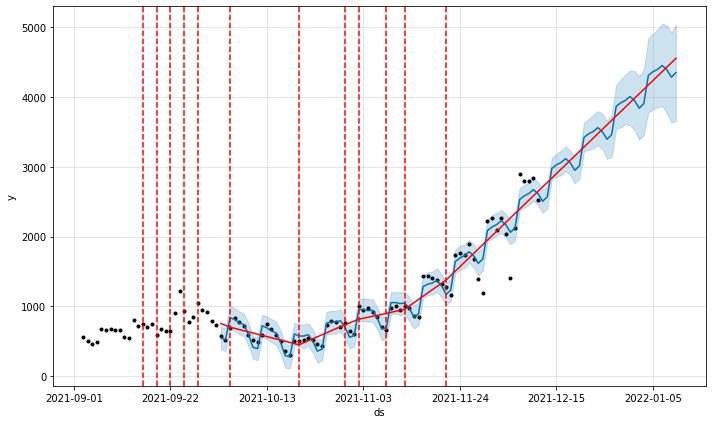

In [67]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### flexibility 조절

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

flexibility **계수가 낮으면 과소적합, 높으면 과대적합**하여 예측하게 됩니다.

중요한 hyperparameter 입니다.

08:43:37 - cmdstanpy - INFO - Chain [1] start processing
08:43:38 - cmdstanpy - INFO - Chain [1] done processing


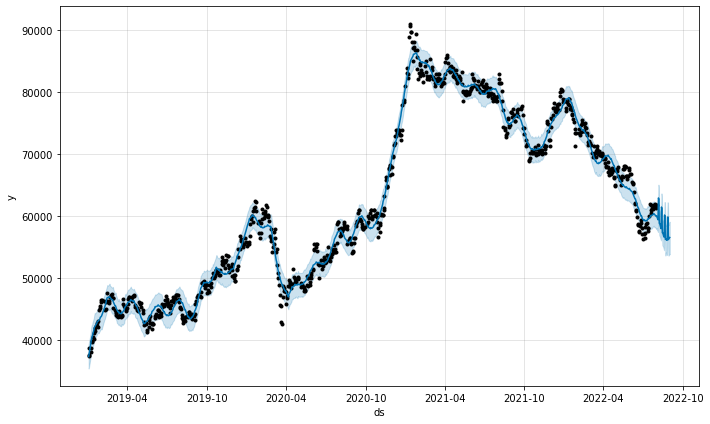

In [34]:
m = Prophet(changepoint_prior_scale=0.8) #이것으로 결과가 달라진다. 
#숫자 그면 과대적합 -> 뜻은 과대적합일수록 민감하게 작용한다. 
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)

08:43:44 - cmdstanpy - INFO - Chain [1] start processing
08:43:44 - cmdstanpy - INFO - Chain [1] done processing


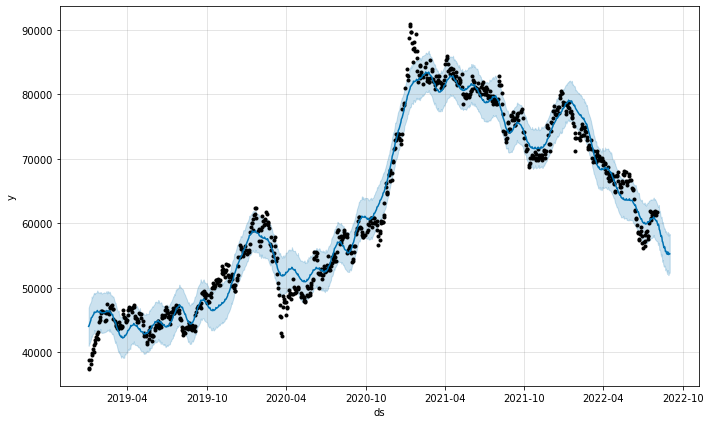

In [35]:
m = Prophet(changepoint_prior_scale=0.01) #둔감하게 반응하여서 큰 틀을 보여준다. 
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)

## 서울시 코로나 확진자 현황

In [ ]:
#이 데이터로 시계열 데이터 분석을 진행해본 것이다. 

[데이터셋 다운로드](http://data.seoul.go.kr/dataList/OA-20279/S/1/datasetView.do)

In [36]:
# 서울시 코로나 확진자 데이터 다운로드
!wget -O seoul_covid.csv https://www.dropbox.com/s/vv9mh6ciq9xnart/seoul_covid19.csv?dl=1

--2022-08-02 08:43:50--  https://www.dropbox.com/s/vv9mh6ciq9xnart/seoul_covid19.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/vv9mh6ciq9xnart/seoul_covid19.csv [following]
--2022-08-02 08:43:51--  https://www.dropbox.com/s/dl/vv9mh6ciq9xnart/seoul_covid19.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc14ebad7fcf71b93ffd2c46f158.dl.dropboxusercontent.com/cd/0/get/BqPRMCiW94CnbGh8jrVCWipCDP0K52jQYm0MaB5_PmykN628SLybxp2Fx6lfAgCSCry2mtPRLtIZ9bzUaNUbRE4RpZz0mcJKifoIH7QjZOIcZKLOBQp_-AxkR11KhoV7-sRHJ63jUFyvld0LGz4uj3N66oJUiFvOZvvMNxJ5s7sADOIkE3TTWXHm9o_9Eu0P5q4/file?dl=1# [following]
--2022-08-02 08:43:51--  https://uc14ebad7fcf71b93ffd2c46f158.dl.dropboxusercontent.com/cd/0/get/BqPRMCiW94CnbGh8jrVCWipCDP0K

In [37]:
corona = pd.read_csv('seoul_covid.csv')
corona

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,182558,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1,182557,2021-12-11,NaN,NaN,NaN,성북구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
2,182556,2021-12-11,NaN,NaN,NaN,중구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
3,182555,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
4,182554,2021-12-11,NaN,NaN,NaN,광진구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182553,5,2020-01-31,9.0,NaN,650909-1,성북구,NaN,기타 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182554,4,2020-01-30,7.0,NaN,561220-1,마포구,중국,해외유입,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182555,3,2020-01-30,6.0,NaN,810212-1,종로구,NaN,종로구 집단발병,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182556,2,2020-01-30,5.0,NaN,400415-1,중랑구,중국,해외유입,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y


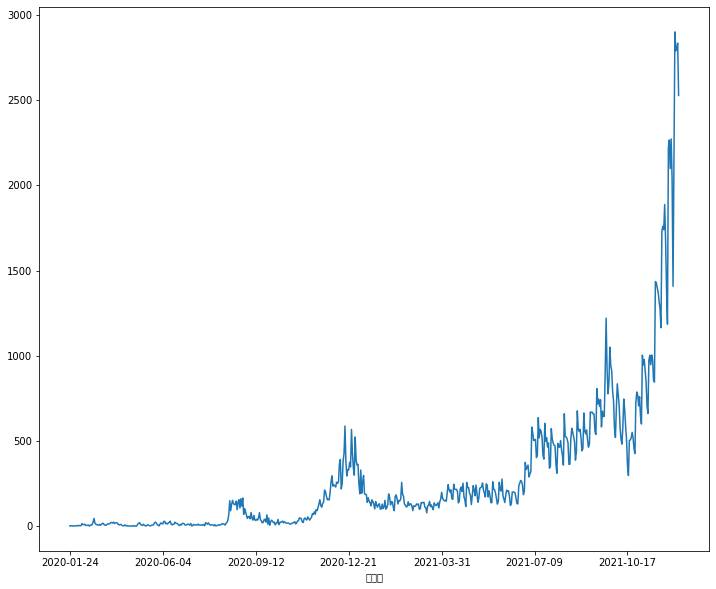

In [38]:
plt.figure(figsize=(12, 10))
corona.groupby('확진일')['연번'].count().plot()
plt.show()

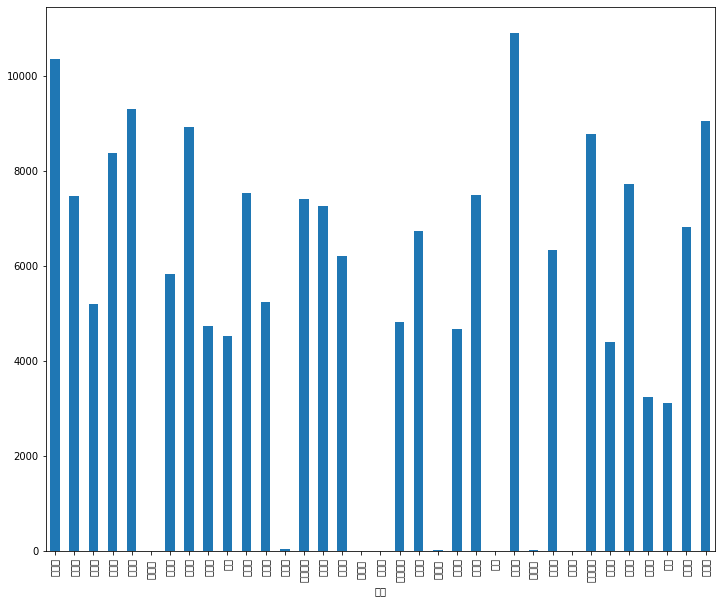

In [39]:
plt.figure(figsize=(12, 10))
corona.groupby('지역')['연번'].count().plot(kind='bar')
plt.show()

## 정확한 분석을 위한 데이터 클린징

공백이 들어간 경우

In [40]:
corona.loc[corona['지역'] == '관악구 ']

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
1428,181130,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1464,181094,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1774,180784,2021-12-11,NaN,NaN,NaN,관악구,NaN,기타 확진자 접촉,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
12155,170403,2021-12-07,NaN,NaN,NaN,관악구,NaN,기타 확진자 접촉,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y


공백이 들어가지 않은 경우

In [41]:
corona.loc[corona['지역'] == '관악구']

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
40,182518,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
51,182507,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
70,182488,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
91,182467,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
200,182358,2021-12-11,NaN,NaN,NaN,관악구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182440,118,2020-03-07,6845.0,NaN,510419-1,관악구,NaN,타시도 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182471,87,2020-02-29,3491.0,NaN,690602-1,관악구,NaN,타시도 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182484,74,2020-02-28,2466.0,NaN,700817-1,관악구,NaN,기타 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y
182505,53,2020-02-26,1295.0,NaN,800216-1,관악구,NaN,타시도 확진자 접촉,NaN,퇴원,NaN,2021-05-27 11:08,2021-05-27 11:08,Y


공백을 제거하는 함수 `strip()`활용

In [42]:
corona['지역'].apply(lambda x: x.strip())

0          기타
1         성북구
2          중구
3          기타
4         광진구
         ... 
182553    성북구
182554    마포구
182555    종로구
182556    중랑구
182557    강서구
Name: 지역, Length: 182558, dtype: object

In [43]:
corona['지역'] = corona['지역'].apply(lambda x: x.strip())

공백이 들어간 데이터가 제거되었음을 확인합니다.

In [44]:
corona.loc[corona['지역'] == '관악구 ']

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부


**구**가 빠진 지역명은 구를 추가합니다.

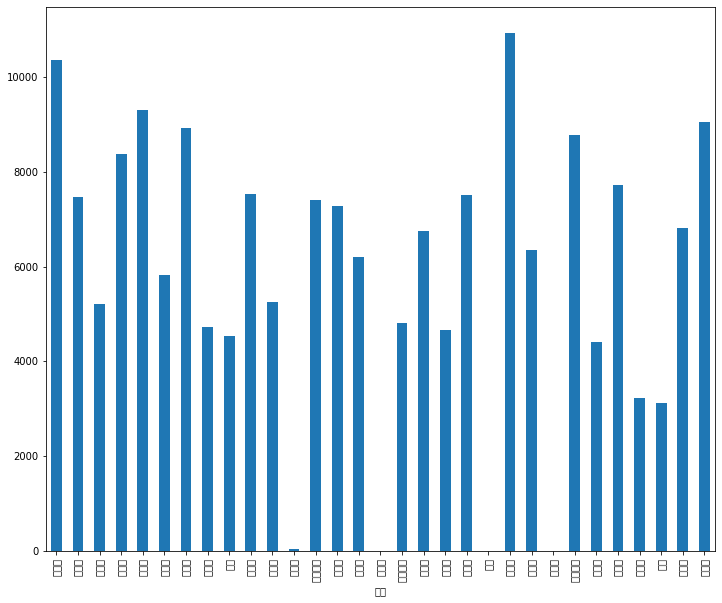

In [45]:
plt.figure(figsize=(12, 10))
corona.groupby('지역')['연번'].count().plot(kind='bar')
plt.show()

In [46]:
target = ['동대문', '서대문', '송파', '영등포']

In [ ]:
corona['지역'].apply(lambda x: x + '구' if x in target else x).value_counts()

In [48]:
corona['지역'] = corona['지역'].apply(lambda x: x + '구' if x in target else x)

지역이 깔끔하게 전처리 되었음을 확인합니다.

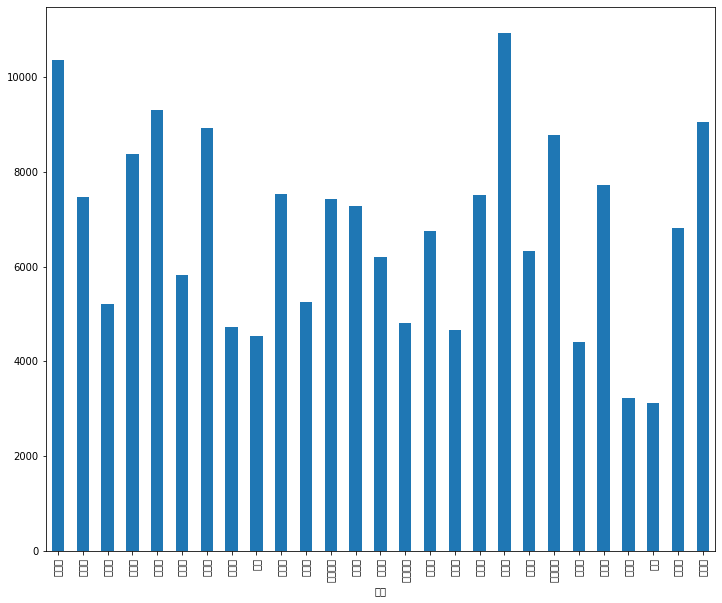

In [49]:
plt.figure(figsize=(12, 10))
corona.groupby('지역')['연번'].count().plot(kind='bar') #연번은 확진자 숫자를 의미한다. 
plt.show()

확진자 숫자를 기준으로 오름차순 정렬합니다.

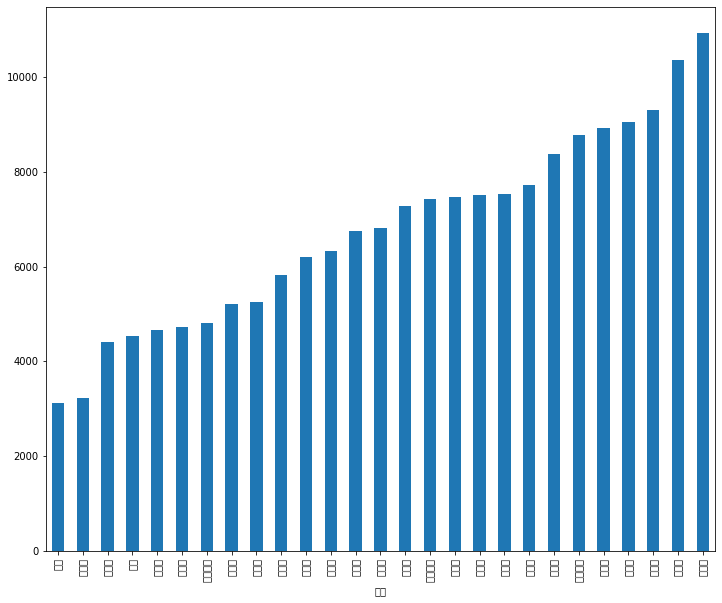

In [50]:
plt.figure(figsize=(12, 10))
corona.groupby('지역')['연번'].count().sort_values().plot(kind='bar')
plt.show()

In [51]:
import folium #지도상에 데이터를 표현하는 시각화 
import requests
import json

In [52]:
# 서울 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

In [53]:
# 위도
latitude = 37.394946
# 경도
longitude = 127.111104

In [54]:
m = folium.Map(
    location=[37.559819, 126.963895],
    zoom_start=10, 
    tiles='cartodbpositron'
)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

m.choropleth(geo_data=seoul_geo,
             data=corona.groupby('지역')['연번'].count().sort_values(),
             fill_color='YlOrRd', # 색상 변경도 가능하다
             fill_opacity=0.3,
             line_opacity=0.2,
             key_on='properties.name',
             legend_name=f'코로나 확진자 현황', 
            )
m

In [55]:
corona.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,182558,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
1,182557,2021-12-11,NaN,NaN,NaN,성북구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
2,182556,2021-12-11,NaN,NaN,NaN,중구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
3,182555,2021-12-11,NaN,NaN,NaN,기타,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y
4,182554,2021-12-11,NaN,NaN,NaN,광진구,NaN,감염경로 조사중,NaN,-,NaN,2021-12-12 10:48,2021-12-12 10:48,Y


In [56]:
corona_df = corona.groupby('확진일')['연번'].count().reset_index()
corona_df

,확진일,연번
0,2020-01-24,1
1,2020-01-30,3
2,2020-01-31,3
3,2020-02-02,1
4,2020-02-05,2
...,...,...
651,2021-12-07,2901
652,2021-12-08,2790
653,2021-12-09,2800
654,2021-12-10,2835


In [57]:
corona_df.columns = ['ds', 'y'] #ds가 일자, y가 확진자 숫자
corona_df

,ds,y
0,2020-01-24,1
1,2020-01-30,3
2,2020-01-31,3
3,2020-02-02,1
4,2020-02-05,2
...,...,...
651,2021-12-07,2901
652,2021-12-08,2790
653,2021-12-09,2800
654,2021-12-10,2835


In [58]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
#changepoint_prior_scale : 얼만큼 유연하게 예측할지(숫자클수록 민감)
#yearly_seasonality : 연간 데이터를 탈건지 -> 이 데이터는 계절 데이터를 반영을 하지는 않을 것 같아서 False
#weekly_seasonality : 이는 있다 -> 주말에 코로나 검사 더많이 받는 영향이 있어서 True로 지정
m = Prophet(changepoint_prior_scale=5.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m.fit(corona_df)

08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:59 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
681,2022-01-06
682,2022-01-07
683,2022-01-08
684,2022-01-09
685,2022-01-10


In [60]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
681,2022-01-06,1861.454195,1634.171912,2150.365714,1758.535221,1966.010096,26.708985,26.708985,26.708985,26.708985,26.708985,26.708985,0.0,0.0,0.0,1888.163180
682,2022-01-07,1871.934651,1630.980492,2168.662580,1759.406210,1985.307671,22.607776,22.607776,22.607776,22.607776,22.607776,22.607776,0.0,0.0,0.0,1894.542427
683,2022-01-08,1882.415107,1624.927588,2130.879467,1764.480698,2004.809949,-3.254219,-3.254219,-3.254219,-3.254219,-3.254219,-3.254219,0.0,0.0,0.0,1879.160888
684,2022-01-09,1892.895563,1557.250209,2091.612777,1763.723901,2028.871325,-59.656174,-59.656174,-59.656174,-59.656174,-59.656174,-59.656174,0.0,0.0,0.0,1833.239388
685,2022-01-10,1903.376019,1559.379852,2137.281109,1763.512423,2050.793735,-55.967544,-55.967544,-55.967544,-55.967544,-55.967544,-55.967544,0.0,0.0,0.0,1847.408475


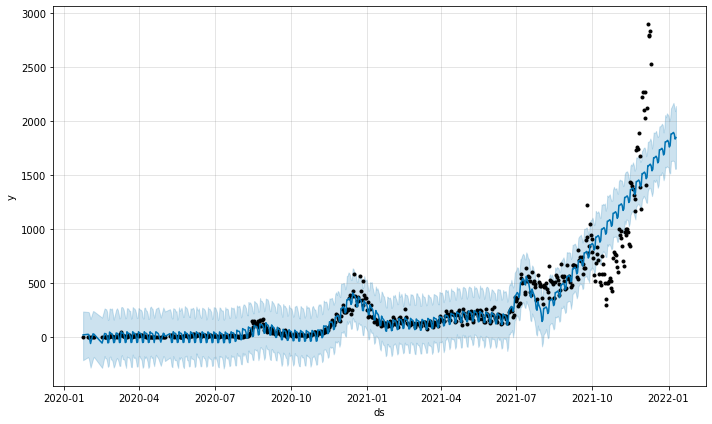

In [61]:
#plot으로 확진자 예측
fig = m.plot(forecast)

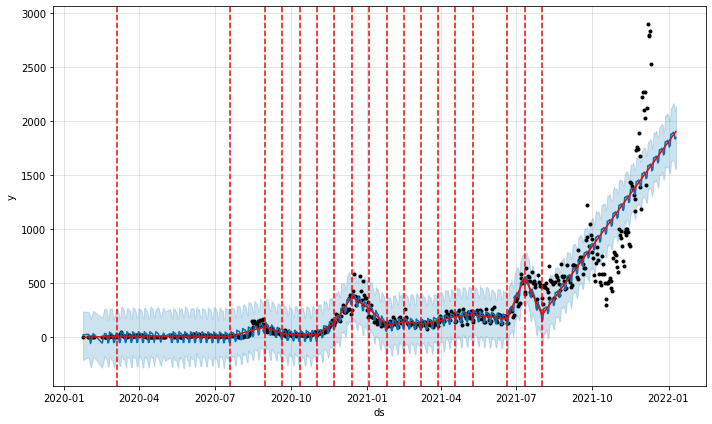

In [63]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

08:45:22 - cmdstanpy - INFO - Chain [1] start processing
08:45:22 - cmdstanpy - INFO - Chain [1] done processing


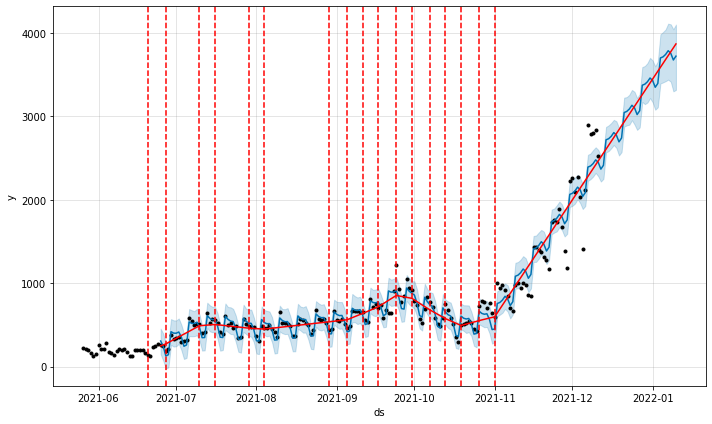

In [64]:
# 최근 N일 데이터로 시뮬레이션 결과
N = 200     #최근 200일 -> 잘 반영이 된 편이었다. 
m = Prophet(changepoint_prior_scale=1.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
forecast = m.fit(corona_df.iloc[-N:]).predict(future.iloc[-N:])
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

08:45:25 - cmdstanpy - INFO - Chain [1] start processing
08:45:25 - cmdstanpy - INFO - Chain [1] done processing


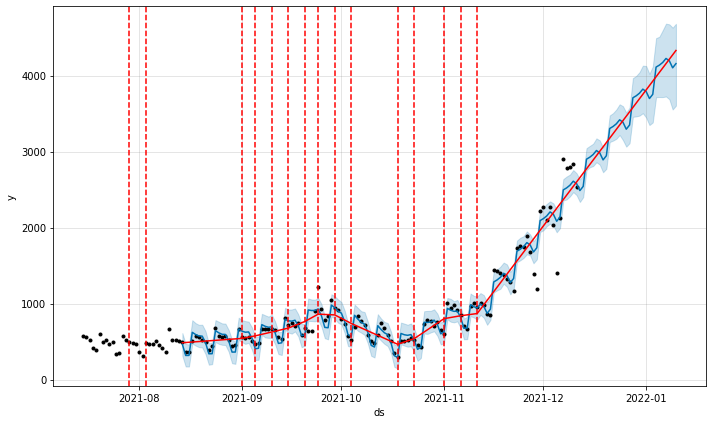

In [65]:
# 최근 N일 데이터로 시뮬레이션 결과
N = 150     #최근 150일 -> 조금 퍼지면서 나타남 
m = Prophet(changepoint_prior_scale=1.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
forecast = m.fit(corona_df.iloc[-N:]).predict(future.iloc[-N:])
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing


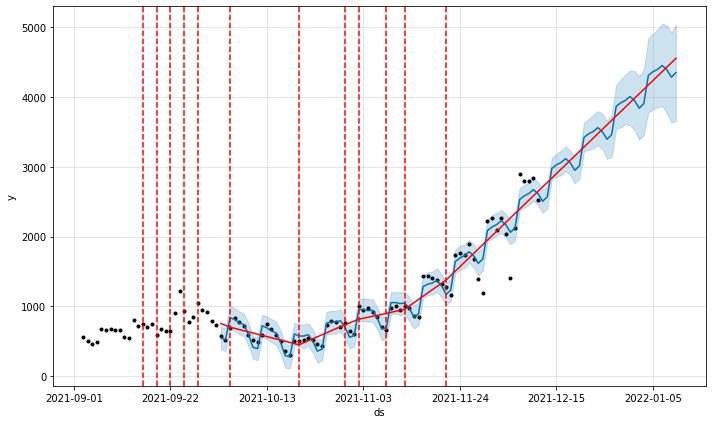

In [66]:
# 최근 N일 데이터로 시뮬레이션 결과
N = 100  #최근 100일  -> 유연한 결과가 나타남 
#몇일을 넣느냐에 따라 예측 결과가 다르게 나타나는 것을 알아보았다.
m = Prophet(changepoint_prior_scale=1.5, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
forecast = m.fit(corona_df.iloc[-N:]).predict(future.iloc[-N:])
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)